# Battle the neighborhood
## This is the capstone project of IBM data science professional certification. The project is intended to find the similar neighborhood to move in based on the current one.

In [225]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import geocoder
import folium
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [280]:
from sklearn.cluster import KMeans

In [3]:
results = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [4]:
source = BeautifulSoup(results,'html')

In [5]:
table = source.body.find_all('table')
feasible = table[0].contents[1]

In [34]:
#Scraping data from wikipedia
df = pd.DataFrame(columns=['Postal Code','Borough','Neighborhood'])
i = 1
for child in feasible.contents:
    #All objects under odd number is useful to use
    if i % 2 == 0:
        i += 1
        continue
    if i != 1:
        header = child.contents
        header = list(filter(lambda a: a !='\n', header))
        pcode = header[0].contents[0].replace('\n','')
        borough = header[1].contents[0].replace('\n','')
        nb = header[2].contents[0].replace('\n','')
        if borough != 'Not assigned':
            df = df.append({'Postal Code':pcode,'Borough':borough,'Neighborhood':nb},ignore_index=True)
    i += 1

In [12]:
latlong = pd.read_csv('https://cocl.us/Geospatial_data')

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [37]:
df = df.merge(latlong,left_on='Postal Code',right_on='Postal Code')

In [406]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Now we visualize all neighborhoods on the map

In [99]:
toronto = folium.Map([43.6532, -79.3832],zoom_start=12)
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto)  

In [100]:
toronto

### Define Foursquare credential

In [102]:
CLIENT_ID = 'VGMKDIZ2CZL4TPF4DKF5DCWIVAU2LHKBHV2WIGWZ155GKFY3' # your Foursquare ID
CLIENT_SECRET = 'H5ERITJPVBJUUTCKPER1MIE3QWYDSHBUJB5FF0ED5ZKV4AAB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

**Parameters**

In [103]:
LIMIT = 100
RADIUS = 500

***Top 100 venues around each neighborhood with radius of 500 meters***

In [125]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [127]:
tor_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [367]:
venue_cat_dist = tor_venues.groupby('Neighborhood').count().reset_index()[['Venue Category','Neighborhood']]
venue_cat_dist = venue_cat_dist.set_index('Neighborhood')
venue_cat_dist = venue_cat_dist.sort_values('Venue Category',ascending=True)

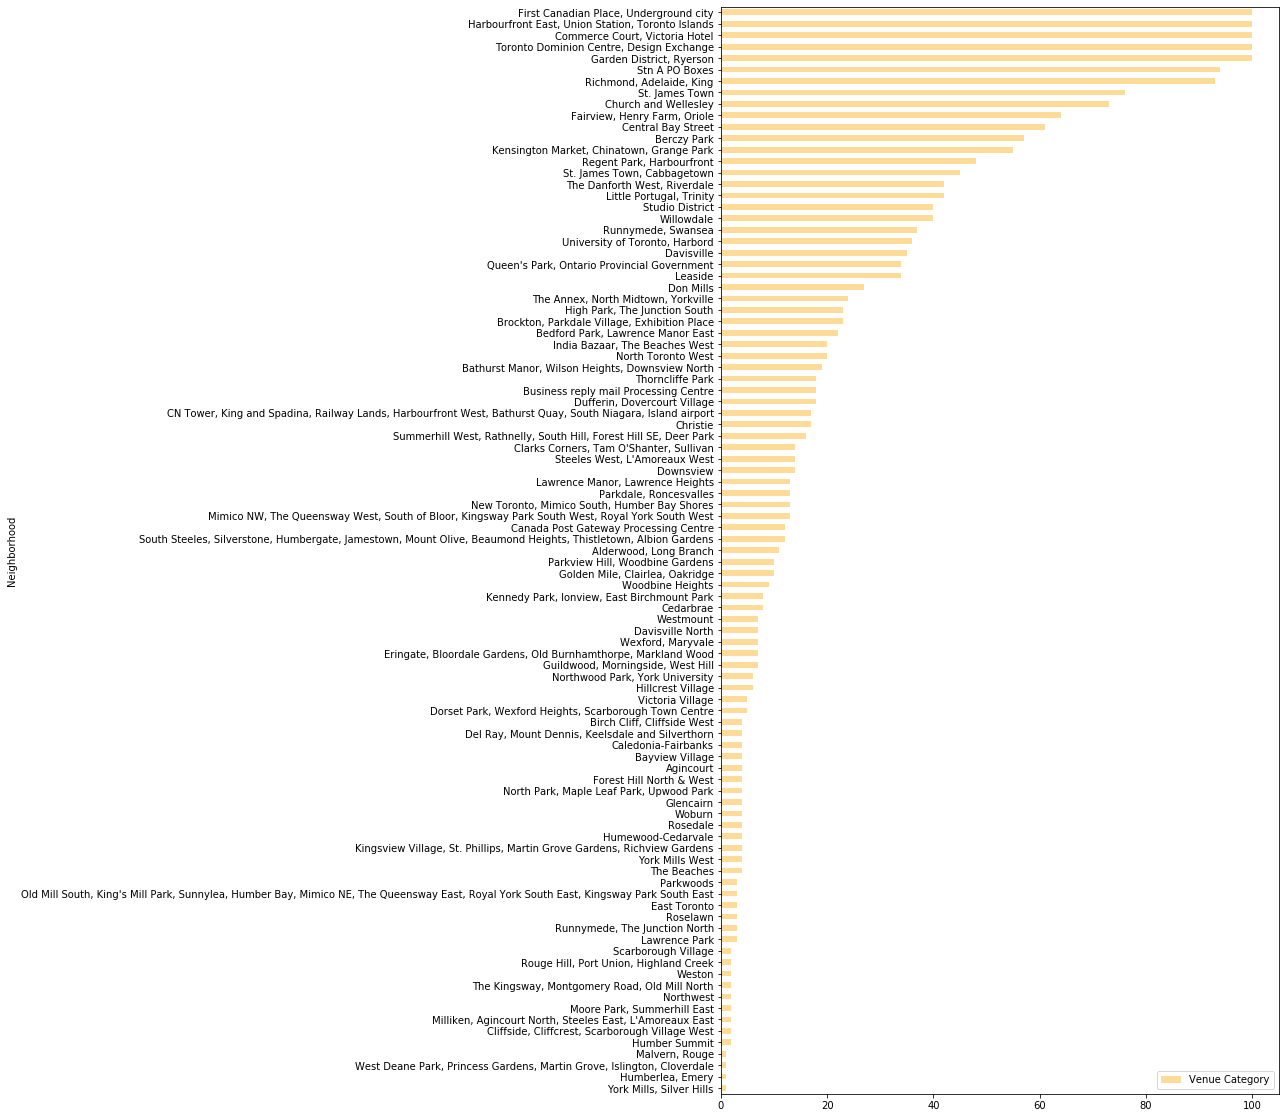

In [368]:
venue_cat_dist.plot(kind='barh',figsize=(10,20),color='orange',alpha=0.4)

#### Encoding all venue categories using one-hot encoding

In [369]:
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 
columns = list(tor_onehot.columns)
columns.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + columns
tor_onehot = tor_onehot[fixed_columns]

In [371]:
tor_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [372]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.052632,0.000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.025,0.0,0.0,0.0,0.0,0.0
91,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
92,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
93,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0


### Find the top 10 common venues in each neighborhood

In [373]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()

In [374]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [375]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_s = pd.DataFrame(columns=columns)
neighborhoods_venues_s['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_s.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_s.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Clothing Store,Breakfast Spot,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pub,Pharmacy,Skating Rink,Athletics & Sports,Pool,Sandwich Place,Dance Studio,Coffee Shop,Gym
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pizza Place,Pharmacy,Ice Cream Shop,Sushi Restaurant,Deli / Bodega,Shopping Mall,Restaurant,Fried Chicken Joint
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Restaurant,Italian Restaurant,Pharmacy,Indian Restaurant,Café,Pub,Sushi Restaurant,Liquor Store


### Clustering using KMean

In [349]:
train = tor_grouped.drop('Neighborhood',axis=1)

In [350]:
clusters = 5
kmeans = KMeans(n_clusters=clusters, random_state=0)
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [351]:
labels = kmeans.labels_

### Now we add cluster labels as well as lat&long to our dataset to plot map

In [397]:
neighborhoods_venues_s.insert(0, 'Cluster Labels', labels)

In [398]:
tor_merged = df
tor_merged = tor_merged.join(neighborhoods_venues_s.set_index('Neighborhood'), on='Neighborhood')

In [399]:
index = tor_merged[tor_merged['1st Most Common Venue'].isna()].index
tor_merged.drop(index,axis=0,inplace=True)

In [400]:
tor_merged.drop('Postal Code',1,inplace=True)

In [401]:
tor_merged['Cluster Labels'].unique()

array([2., 1., 0., 3., 4.])

In [403]:
neighborhood_cluster = folium.Map([43.6532, -79.3832],zoom_start=12)
color_set = ['#ff0000','#3186cc','#a89632','#ff6a3d','#583bff']
for lat, lng, borough, neighborhood, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Borough'], tor_merged['Neighborhood'],tor_merged['Cluster Labels']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color_set[int(cluster)-1],
        fill=True,
        fill_color = color_set[int(cluster)-1],
        fill_opacity=1,
        parse_html=False).add_to(neighborhood_cluster) 

In [404]:
neighborhood_cluster